### HEAD

In [2]:
import math
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import operator

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from functools import reduce
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from typing import List, Callable, Tuple, Union
from dtaidistance import dtw
from datetime import timedelta, datetime
from src import plot_time_series


import warnings
warnings.filterwarnings("ignore")

### Params

In [3]:
metric_name = "rto"
id_field_name = "CityName"
time_series_field = "dt"
number_of_neighbours = 3
test_units = ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']
alpha = 0.05
cuped_time = 14

In [4]:
# введем переменные с датами
start_of_test = "2022-04-07"
days_for_knn = 70
days_for_validation = 14
days_for_test = 28

end_of_test = (datetime.strptime(start_of_test, "%Y-%m-%d") + timedelta(days=days_for_test)).strftime("%Y-%m-%d")
start_of_validation = (datetime.strptime(start_of_test, "%Y-%m-%d") + timedelta(days=-days_for_validation)).strftime("%Y-%m-%d")
start_of_knn = (datetime.strptime(start_of_validation, "%Y-%m-%d") + timedelta(days=-days_for_knn)).strftime("%Y-%m-%d")

print(f"Подбор групп: с {start_of_knn} по {start_of_validation}")
print(f"Валидация: с {start_of_validation} по {start_of_test}")
print(f"Тест: с {start_of_test} по {end_of_test}")

Подбор групп: с 2022-01-13 по 2022-03-24
Валидация: с 2022-03-24 по 2022-04-07
Тест: с 2022-04-07 по 2022-05-05


In [5]:
def create_periods(start_of_test: str) -> Tuple[str]:
    end_of_test = (
        datetime.strptime(start_of_test, "%Y-%m-%d")
        + timedelta(days=days_for_test)
    ).strftime("%Y-%m-%d")
    start_of_validation = (
        datetime.strptime(start_of_test, "%Y-%m-%d")
        + timedelta(days=-days_for_validation)
    ).strftime("%Y-%m-%d")
    start_of_knn = (
        datetime.strptime(start_of_validation, "%Y-%m-%d")
        + timedelta(days=-days_for_knn)
    ).strftime("%Y-%m-%d")
    print(f"Подбор групп: с {start_of_knn} по {start_of_validation}")
    print(f"Валидация: с {start_of_validation} по {start_of_test}")
    print(f"Тест: с {start_of_test} по {end_of_test}")
    return start_of_knn, start_of_validation, start_of_test

In [6]:
create_periods(start_of_test)

Подбор групп: с 2022-01-13 по 2022-03-24
Валидация: с 2022-03-24 по 2022-04-07
Тест: с 2022-04-07 по 2022-05-05


('2022-01-13', '2022-03-24', '2022-04-07')

In [146]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [147]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [148]:
# данные для обучения knn
knn_data = df[
    (df['dt'] >= start_of_knn) & (df['dt'] < start_of_validation)
    & (df['OrderSource'] == 'web') & (df['Category'] == 'пицца')
    ]
knn_data.shape

(18420, 14)

##### Обработка KNN данных

In [149]:
knn_data = knn_data[["dt", "CityName", "rto"]]
knn_data = knn_data[~knn_data["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [150]:
knn_data.head()

,dt,CityName,rto
36170,2022-01-13,Абакан,30913.82
36182,2022-01-13,Абинск,3409.35
36193,2022-01-13,Азов,10963.47
36204,2022-01-13,Аксай Россия,11807.18
36214,2022-01-13,Александров,8372.84


In [151]:
knn_data_pivot = knn_data.pivot_table(values=metric_name, columns=time_series_field, index=id_field_name)

In [152]:
cols = list(knn_data_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = knn_data_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [153]:
# оставляем города, включая мск и спб, кроме тех, где есть пропуски в данных
test_wo_denied_ = [i for i in set(knn_data[id_field_name]) if i not in wrong_cities]

In [154]:
len(test_wo_denied_)

225

In [155]:
knn_data_clean = knn_data[knn_data[id_field_name].isin(test_wo_denied_)]

In [156]:
knn_data.head()

,dt,CityName,rto
36170,2022-01-13,Абакан,30913.82
36182,2022-01-13,Абинск,3409.35
36193,2022-01-13,Азов,10963.47
36204,2022-01-13,Аксай Россия,11807.18
36214,2022-01-13,Александров,8372.84


In [157]:
set(test_units)

{'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск', 'Пенза', 'Уфа'}

In [158]:
set(knn_data[knn_data["CityName"].isin(test_units)]["CityName"])

{'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск', 'Пенза', 'Уфа'}

### FUNCs

In [21]:
def get_scaled_data(data: pd.DataFrame, metric_name: str) -> pd.DataFrame:
    """
    Метод для масштабирования данных. Используется StandardScaler

    Args:
        data (pd.DataFrame): датафрейм с датами, юнитами и метрикой
        metric_name (str): наменование столбца с метрикой

    Raises:
        KeyError: В случае, если наименование столбца с метрикой указано
        неверно, бросается исключение

    Returns:
        pd.DataFrame: исходный датафрейм + масштабированная метрика
    """
    try:
        scaled_metric = StandardScaler().fit_transform(data[[metric_name]])
    except KeyError:
        raise KeyError(f"Frame data does not contain the field with name {metric_name}")
    data[f"scaled_{metric_name}"] = scaled_metric
    return data

In [159]:
knn_pre_exp_clean_scld = get_scaled_data(knn_data_clean, metric_name)

In [23]:
knn_pre_exp_clean_scld.head()

,dt,CityName,rto,scaled_rto
7,2022-01-01,Абакан,39132.1742,0.026246
19,2022-01-01,Абинск,8357.3700,-0.568868
30,2022-01-01,Азов,9856.7700,-0.539873
39,2022-01-01,Аксай Россия,4148.3400,-0.650261
51,2022-01-01,Александров,8407.3500,-0.567902


In [24]:
def get_vectors(data: pd.DataFrame, metric_name: str, id_field_name: str) -> Tuple[dict, dict]:
    """
    Преобразует метрику из датафрейма в векторный вид

    Args:
        data (pd.DataFrame): датафрейм c масштабированной метрикой
        metric_name (str): наименование столбца с масштабированной метрикой
        id_field_name (str): наименование столбца с юнитом

    Returns:
        Tuple[dict, dict]:
            dict0 - словарь с наименованием юнита в ключе и вектором в значении
            dict1 - словарь с индексом юнита в ключе и наименованием юнита в значении
    """
    data_vec = data.groupby(id_field_name).agg({f"scaled_{metric_name}": list}).reset_index()
    data_vec[f"{metric_name}_array"] = [np.array(i) for i in data_vec[f"scaled_{metric_name}"]]
    keys = data_vec[id_field_name].tolist()
    vals = data_vec[f"{metric_name}_array"].tolist()
    return dict(zip(keys, vals)), dict(zip([i for i in range(0, len(keys))], keys))

In [160]:
knn_vectors, ids_dict = get_vectors(knn_pre_exp_clean_scld, metric_name, id_field_name)

In [28]:
def get_k_neighbors_default(
    id: str, vectors: dict, number_of_neighbours: int, algorithm='auto'
) -> dict:
    """
    Возвращает k ближайших соседей для одного заданного юнита

    Args:
        id (str): идентификатор юнита
        vectors (dict): словарь с наименованием юнита в ключе и вектором метрики в значении 
        number_of_neighbours (int): количество ближайших соседей для поиска
        algorithm (str, optional): алгорит подбора соседей. Defaults to 'auto'.

    Returns:
        dict: словарь с индексами юнитов в ключах и расстоянием в значении
    """
    def get_knn(vectors):
        vector_arrays = [list(i) for i in vectors.values()]
        return NearestNeighbors(number_of_neighbours, algorithm=algorithm).fit(vector_arrays)        

    def get_vector(vectors, id):
        return vectors[id].reshape(1, -1)

    def flatten_neighbour_list(distance, ids):
        dist_list, nb_list = distance.tolist(), ids.tolist()
        return dist_list[0], nb_list[0]

    knn = get_knn(vectors)
    vector = get_vector(vectors, id)
    dist, nb_indexes = knn.kneighbors(vector, number_of_neighbours, return_distance=True)
    return_dist, return_nb_indexes = flatten_neighbour_list(dist, nb_indexes)
    return dict(zip(return_nb_indexes, return_dist))

In [32]:
def get_k_neighbors_dtw(data_dict: dict, target_id: str, n_neighbors=1) -> dict:
    """
    Находит ближайших соседей по расстоянию DTW для заданного временного ряда

    Args:
        data_dict (dict): словарь, где ключи — идентификаторы наблюдений, значения — вектора временных рядов
        target_id (str): идентификатор временного ряда, для которого ищутся соседи
        n_neighbors (int, optional): количество ближайших соседей, которые нужно вернуть. Defaults to 1.

    Returns:
        nearest_neighbors (dict): словарь, где ключи — идентификаторы ближайших соседей, значения — расстояния DTW
    """
    target_vector = data_dict[target_id]
    distances = {}
    for key, vector in data_dict.items():
        if key != target_id:
            distances[key] = dtw.distance(vector, target_vector)    
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])
    nearest_neighbors = dict(sorted_distances[:n_neighbors])
    return nearest_neighbors

In [33]:
get_k_neighbors_default("Орск", knn_vectors, 3)

{152: 0.0, 190: 0.7594478829269001, 77: 0.7652548710999338}

In [34]:
ids_dict[190], ids_dict[77]

('Стерлитамак', 'Кириши')

In [35]:
get_k_neighbors_dtw(knn_vectors, "Орск", 3)

{'Кронштадт': 0.5387766979939548,
 'Прокопьевск': 0.5431580296880775,
 'Горно-Алтайск': 0.5700736014197976}

In [37]:
def get_all_neighbours_eucl(
    knn_vectors: dict, ids_dict: dict, test_units: List[str], number_of_neighbours: int
) -> dict:
    """
    Возвращает словарь с ближайшими соседями для всех, поданных на вход юнитов.
    Метод поиска - KMeans (eucl).

    Args:
        knn_vectors (dict): словарь с наименованием юнита в ключе и вектором в значении
        ids_dict (dict): словарь с индексом юнита в ключе и наименованием юнита в значении
        test_units (List[str]): список юнитов из тестовой группы
        number_of_neighbours (int): количество ближайших соседей

    Returns:
        dict: словарь с наменованием юнита в ключе и списком соседей в значении
    """
    result_ids = {
        i:[ids_dict[j] for j in get_k_neighbors_default(i, knn_vectors, number_of_neighbours + 1) if ids_dict[j] != i]
        for i in test_units
    }
    return result_ids

In [38]:
def get_all_neighbours_dtw(knn_vectors: dict, number_of_neighbours: int, test_units: List[str]):
    """
    Возвращает словарь с ближайшими соседями для всех, поданных на вход юнитов.
    Метод поиска - dynamic time warping.

    Args:
        knn_vectors (dict): словарь с наименованием юнита в ключе и вектором в значении
        test_units (List[str]): список юнитов из тестовой группы
        number_of_neighbours (int): количество ближайших соседей

    Returns:
        dict: словарь с наменованием юнита в ключе и списком соседей в значении
    """
    res = {
        i:[j for j in get_k_neighbors_dtw(knn_vectors, i, number_of_neighbours)] for i in test_units
    }
    return res

In [161]:
all_neighbours_dtw = get_all_neighbours_dtw(knn_vectors, number_of_neighbours, test_units)
all_neighbours_dtw

{'Пенза': ['Рязань', 'Чита', 'Благовещенск'],
 'Уфа': ['Оренбург', 'Волгоград', 'Томск'],
 'Курск': ['Волжский', 'Березники', 'Братск'],
 'Нижний Тагил': ['Мурино', 'Парголово', 'Братск'],
 'Новокуйбышевск': ['Альметьевск', 'Красное Село', 'Звенигород'],
 'Орск': ['Анапа', 'Прокопьевск', 'Стерлитамак']}

In [162]:
all_neighbours_eucl = get_all_neighbours_eucl(knn_vectors, ids_dict, test_units, number_of_neighbours)
all_neighbours_eucl

{'Пенза': ['Чита', 'Рязань', 'Смоленск'],
 'Уфа': ['Оренбург', 'Томск', 'Волгоград'],
 'Курск': ['Братск', 'Надым', 'Колпино'],
 'Нижний Тагил': ['Брянск', 'Бердск', 'Мурино'],
 'Новокуйбышевск': ['Альметьевск', 'Красное Село', 'Верхняя Пышма'],
 'Орск': ['Салават', 'Стерлитамак', 'Кириши']}

In [41]:
def get_test_control_groups(neighbours_dict: dict, test_units: List[str]) -> dict:
    """
    Формирует словарь со списками тестовых и контрольных юнитов в значениях словаря

    Args:
        neighbours_dict (dict): словарь с наменованием юнита в ключе и списком соседей в значении
        test_units (List[str]): список юнитов из тестовой группы

    Returns:
        dict: итоговый словарь {test_units: [str], control_units: [str]}
    """
    test_units = list(neighbours_dict.keys())
    control_units = [[j for j in i if j not in test_units][0] for i in neighbours_dict.values()]
    return dict(
        test_units=test_units,
        control_units=control_units,
    )

In [163]:
all_groups_dtw = get_test_control_groups(all_neighbours_dtw, test_units)
all_groups_dtw

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань',
  'Оренбург',
  'Волжский',
  'Мурино',
  'Альметьевск',
  'Анапа']}

In [164]:
all_groups_eucl = get_test_control_groups(all_neighbours_eucl, test_units)
all_groups_eucl

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Чита',
  'Оренбург',
  'Братск',
  'Брянск',
  'Альметьевск',
  'Салават']}

### VIZ

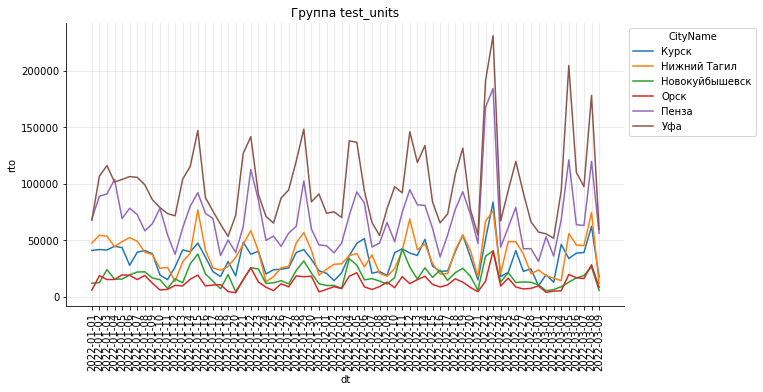

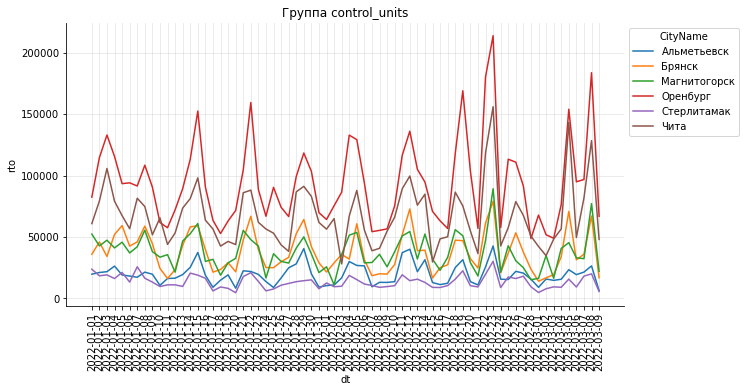

In [44]:
for i in all_groups_eucl.keys():

    plot_time_series(
        df=knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_eucl[i])],
        metric_name=metric_name,
        grouped_column=id_field_name,
        time_series_name=time_series_field,
        title=f"Группа {i}"
    )

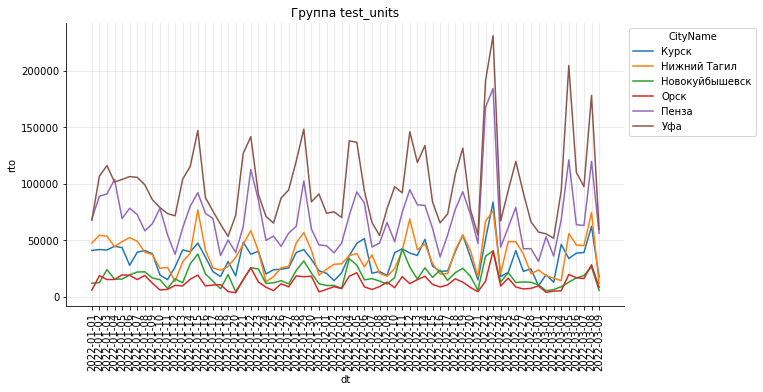

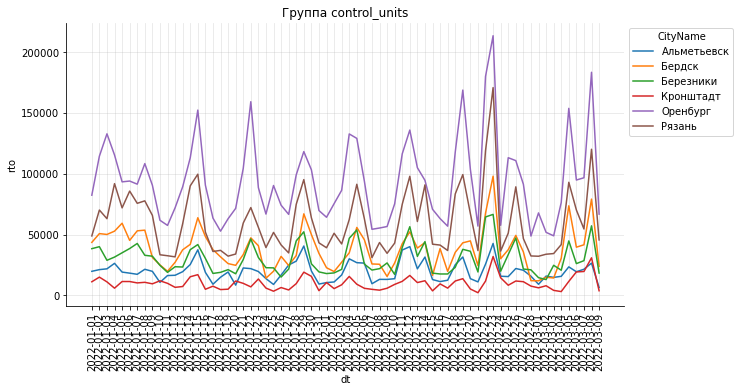

In [211]:
for i in all_groups_dtw.keys():

    plot_time_series(
        df=knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw[i])],
        metric_name=metric_name,
        grouped_column=id_field_name,
        time_series_name=time_series_field,
        title=f"Группа {i}"
    )

In [165]:
test_group_std = np.std(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["test_units"])][metric_name])
control_group_std_dtw = np.std(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["control_units"])][metric_name])
control_group_std_eucl = np.std(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_eucl["control_units"])][metric_name])
test_group_std, control_group_std_dtw, control_group_std_eucl

(36405.25346595708, 33664.7548068533, 34028.374814063405)

In [166]:
test_group_mean = np.mean(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["test_units"])][metric_name])
control_group_mean_dtw = np.mean(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["control_units"])][metric_name])
control_group_mean_eucl = np.mean(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_eucl["control_units"])][metric_name])
test_group_mean, control_group_mean_dtw, control_group_mean_eucl

(42881.70867833339, 40363.8390466667, 41845.31087500002)

In [167]:
def plot_ci(difference: List[float], point_estimation: float, ci: Tuple[float, float]) -> None:
    """
    Визуализирует доверительный интервал

    Args:
        difference (List[float]): _description_
        point_estimation (float): _description_
        ci (Tuple[float, float]): _description_
    """
    ax = sns.kdeplot(difference, label='kde статистики', fill=False, color='crimson')
    kdeline = ax.lines[0]
    plt.plot([point_estimation], [0], 'o', c='k', markersize=6, label='точечная оценка')
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    ax.vlines(point_estimation, 0, np.interp(point_estimation, xs, ys), color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(ci[0] <= xs) & (xs <= ci[1]), interpolate=True, facecolor='crimson', alpha=0.2)
    plt.grid(alpha=0.3)
    plt.title('Доверительный интервал')
    plt.legend()
    plt.show()

In [168]:
def get_percentile_ci(bootstrap_stats: List[float], alpha: float=0.05) -> Tuple[float, float]:
    """
    Строит перцентильный доверительный интервал

    Args:
        bootstrap_stats (List[float]): бутстрапированная статистика
        alpha (float, optional): Уровень ошибки первого рода. Defaults to 0.05.

    Returns:
        Tuple[float, float]: границы доверительного интервала
    """
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right


def get_normal_ci(
    bootstrap_stats: Union[np.array, List], pe: float, alpha: float=0.05
) -> Tuple[float, float]:
    """
    Строит нормальный доверительный интервал.

    Args:
        bootstrap_stats (Union[np.array, List]): массив значений посчитанной метрики
        pe (float): точечная оценка (рассчитывается на исходных данных)
        alpha (float, optional): Уровень ошибки первого рода. Defaults to 0.05.

    Returns:
        Tuple[float, float]: границы доверительного интервала
    """
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

### BOOTSTRAP

In [188]:
def bootstrap(
    control_group: np.array,
    test_group: np.array,
    metric_func: Callable,
    bootstrap_group_length: int,
    effect: int,
    alpha: float = 0.05,
    n_iter: int = 100_000,
    verbose: bool = False
) -> dict:
    """
    Бутстрап

    Args:
        control_group (np.array): массив значений целевой метрики в контрольной группе
        test_group (np.array): массив значений целевой метрики в тестовой группе
        metric_func (Callable): статистика расчета целевой метрики
        bootstrap_group_length (int): длина бутстрап выборки
        effect (int): искусственный эффект
        alpha (float, optional): уровень ошибки первого рода. Defaults to 0.05.
        n_iter (int, optional): количество итераций. Defaults to 10_000.
        verbose (bool, optional): печать вывода. Defaults to False.

    Returns:
        dict: словарь с рассчитанными параметрами
    """
    def _help_function(func: Callable, group: np.ndarray) -> Callable:
        return func(group)
    difference_aa = np.zeros(n_iter)
    difference_ab = np.zeros(n_iter)
    for i in range(n_iter):
        random_values_control = np.random.choice(control_group, bootstrap_group_length, True)
        random_values_test = np.random.choice(test_group, bootstrap_group_length, True)
        random_values_test_with_eff = np.random.choice(test_group + effect, bootstrap_group_length, True)

        control_metric = _help_function(metric_func, random_values_control)
        test_metric = _help_function(metric_func, random_values_test)
        test_metric_with_eff = _help_function(metric_func, random_values_test_with_eff)

        difference_aa[i] = test_metric - control_metric
        difference_ab[i] = test_metric_with_eff - control_metric
    # Расчет точечных оценок
    point_estimation_aa = (
        _help_function(metric_func, test_group) - _help_function(metric_func, control_group)
    )
    point_estimation_ab = (
        _help_function(metric_func, test_group + effect) - _help_function(metric_func, control_group)
    )

    # Считаем p-value
    adj_diffs_aa = difference_aa - point_estimation_aa
    adj_diffs_ab = difference_ab - point_estimation_ab
    false_positive_aa = np.sum(np.abs(adj_diffs_aa) >= np.abs(point_estimation_aa))
    false_positive_ab = np.sum(np.abs(adj_diffs_ab) >= np.abs(point_estimation_ab))
    p_value_aa_boot = false_positive_aa / n_iter
    p_value_ab_boot = false_positive_ab / n_iter

    # Расчет доверительных интервалов
    ci_aa = get_percentile_ci(difference_aa)
    ci_ab = get_percentile_ci(difference_ab)
    has_effect_aa = not (ci_aa[0] < 0 < ci_aa[1])
    has_effect_ab = not (ci_ab[0] < 0 < ci_ab[1])
    if verbose:
        print("A/A тест")
        print(f'Значение метрики изменилось на: {point_estimation_aa:0.5f}')
        print(
            f'{((1 - alpha) * 100)}% доверительный интервал: '
            f'({ci_aa[0]:0.5f}, {ci_aa[1]:0.5f})'
        )
        print(f'Отличия статистически значимые: {has_effect_aa}')
        print(f"p-value from bootstrap is: {p_value_aa_boot}")
        plot_ci(difference_aa, point_estimation_aa, ci_aa)
        print("------------------")
        print("A/B тест")
        print(f'Значение метрики изменилось на: {point_estimation_ab:0.5f}')
        print(
            f'{((1 - alpha) * 100)}% доверительный интервал: '
            f'({ci_ab[0]:0.5f}, {ci_ab[1]:0.5f})'
        )
        print(f'Отличия статистически значимые: {has_effect_ab}')
        print(f"p-value from bootstrap is: {p_value_ab_boot}")
        plot_ci(difference_ab, point_estimation_ab, ci_ab)
    else:
        return dict(
            aa_test=has_effect_aa,
            ab_test=has_effect_ab,
            pe_aa=point_estimation_aa,
            pe_ab=point_estimation_ab,
            ci_aa=ci_aa,
            ci_ab=ci_ab,
            p_value_aa_boot=p_value_aa_boot,
            p_value_ab_boot=p_value_ab_boot
        )

### VAL

In [178]:
# данные для валидации
all_units = functools.reduce(operator.iconcat, all_groups_dtw.values(), [])
validation_data = df[
    (df['dt'] >= start_of_validation) & (df['dt'] < start_of_test)
    & (df['OrderSource'] == 'web') & (df['Category'] == 'пицца')
    & (df["CityName"].isin(all_units))
    ]
validation_data.shape

(168, 14)

In [179]:
values_control_val = np.array(validation_data[validation_data[id_field_name].isin(all_groups_dtw["control_units"])][metric_name])
values_test_val = np.array(validation_data[validation_data[id_field_name].isin(all_groups_dtw["test_units"])][metric_name])
n = len(np.array(validation_data[validation_data[id_field_name].isin(all_groups_dtw["test_units"])][metric_name]))
len(values_control_val) == len(values_test_val), n

(True, 84)

A/A тест
Значение метрики изменилось на: 3018.87332
95.0% доверительный интервал: (-6967.84880, 13175.05694)
Отличия статистически значимые: False
p-value from bootstrap is: 0.55748


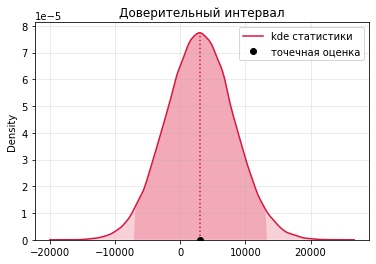

------------------
A/B тест
Значение метрики изменилось на: 10018.87332
95.0% доверительный интервал: (24.45042, 20156.96217)
Отличия статистически значимые: True
p-value from bootstrap is: 0.0512


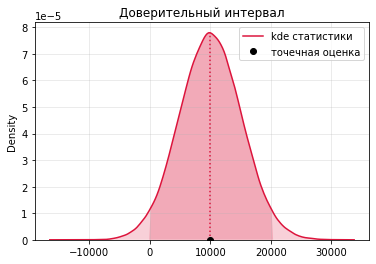

In [191]:
bootstrap(
    values_control_val,
    values_test_val,
    np.mean,
    n,
    7000,
    verbose=True
)

In [ ]:
pval_aa = []
pval_ab = []
eff = 7000
for i in tqdm(range(100)):
    res_dict = bootstrap(
        values_control_val,
        values_test_val,
        np.mean,
        n,
        eff
    )
    pval_aa.append(res_dict["p_value_aa_boot"])
    pval_ab.append(res_dict["p_value_ab_boot"])

In [382]:
get_normal_ci(pval_aa, np.mean(pval_aa))

(0.2627465729177877, 0.2797626270822122)

In [383]:
get_normal_ci(pval_ab, np.mean(pval_ab))

(0.043795638997108165, 0.052190761002891835)

### CUPED

In [58]:
def _calculate_theta(*, y_prepilot: np.array, y_pilot: np.array) -> float:
    """
    Вычисляем Theta

    Args:
        y_prepilot (np.array): значения метрики во время пилота
        y_pilot (np.array): значения ковариант (той же самой метрики) на препилоте

    Returns:
        float: значение коэффициента тета
    """
    covariance = np.cov(y_prepilot.astype(float), y_pilot.astype(float))[0, 1]
    variance = np.var(y_prepilot)
    theta = covariance / variance
    return theta

In [104]:
def calculate_cuped_metric(
    df_history: pd.DataFrame, df_experiment: pd.DataFrame, target_metric_name: str,
    sortmerge_list: List[str]
) -> pd.DataFrame:
    """
    Расчет CUPED метрики

    Args:
        df_history (pd.DataFrame): таблица с данными предпилотными данными
        df_experiment (pd.DataFrame): таблица с данными пилота
        target_metric_name (str): целевая метрика
        sortmerge_list (List[str]): лист с полями для сортировки и соединения таблиц
        theta (float, optional): _description_. Defaults to None.

    Returns:
        pd.DataFrame: датафрейм с cuped метрикой
    """
    prepilot_period = (
        df_history[df_history['period'] == 'history']
        .sort_values(sortmerge_list)
    )
    pilot_period = (
        df_experiment[df_experiment['period'] == 'pilot']
        .sort_values(sortmerge_list)
    )
    theta = _calculate_theta(
        y_prepilot=np.array(prepilot_period[target_metric_name]),
        y_pilot=np.array(pilot_period[target_metric_name])
        )
    res = pd.merge(
        prepilot_period,
        pilot_period,
        how='inner',
        on=sortmerge_list,
        suffixes=["_prepilot", "_pilot"]
    )
    print(f'Theta is: {theta}', )
    res[f'{target_metric_name}_cuped'] = (
        res[f"{target_metric_name}_pilot"] - theta * res[f'{target_metric_name}_prepilot']
    )
    return res

In [63]:
def check_weekday_or_weekend(date: str) -> int:
    """
    Возвращает день недели

    Args:
        date (str): дата в формате %Y-%m-%d

    Returns:
        int: день недели
    """
    given_date = datetime.strptime(date, '%Y-%m-%d')
    day_of_week = (given_date.weekday() + 1)
    return day_of_week

In [192]:
def sort_merge_for_cuped(
    pre_pilot_df: pd.DataFrame,
    pilot_df: pd.DataFrame,
    id_field_name: str,
    cuped_time: int,
    time_series_field: str,
    all_groups: dict
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Формирование и сортировка датафрейма для cuped'a

    Args:
        pre_pilot_df (pd.DataFrame): данные предпилотного периода
        pilot_df (pd.DataFrame): данные пилотного периода
        id_field_name (str): поле с идентификатором
        cuped_time (int): количество дней в предпилотном периоде
        time_series_field (str): поле с датой
        all_groups (dict): все юниты теста

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: данные для cuped'a
    """
    # Определяем день недели
    pre_pilot_df["weekday"] = pre_pilot_df[time_series_field].apply(lambda x: check_weekday_or_weekend(x))
    pilot_df["weekday"] = pilot_df[time_series_field].apply(lambda x: check_weekday_or_weekend(x))
    # Все юниты в тесте и контроле
    all_units = functools.reduce(operator.iconcat, all_groups.values(), [])
    # Предпилотный период
    dates_for_lin = sorted(list(set(pre_pilot_df[time_series_field].values)))[-cuped_time:]
    pre_pilot_df = pre_pilot_df[
        pre_pilot_df[time_series_field].isin(dates_for_lin) & 
        pre_pilot_df[id_field_name].isin(all_units)
    ]    
    pilot_df_sort = pilot_df.sort_values([id_field_name, "weekday"])
    pre_pilot_df_sort = pre_pilot_df.sort_values([id_field_name, "weekday"])
    pilot_df_sort["row_number"] = [i for i in range(0, len(pilot_df_sort))]
    pre_pilot_df_sort["row_number"] = [i for i in range(0, len(pre_pilot_df_sort))]
    pilot_df_sort["period"] = "pilot"
    pre_pilot_df_sort["period"] = "history"
    cols = [time_series_field, id_field_name, metric_name, "weekday", "row_number", "period"]
    return pilot_df_sort[cols], pre_pilot_df_sort[cols]

In [197]:
pilot_df_sort, pre_pilot_df_sort = sort_merge_for_cuped(
    knn_data_clean,
    validation_data,
    id_field_name,
    cuped_time,
    time_series_field,
    all_groups_dtw
)

In [198]:
pilot_df_sort.shape

(168, 6)

In [199]:
pilot_df_sort.head(2)

,dt,CityName,rto,weekday,row_number,period
261026,2022-03-28,Альметьевск,14697.69,1,0,pilot
282240,2022-04-04,Альметьевск,8212.19,1,1,pilot


In [121]:
cuped_df = calculate_cuped_metric(
    pre_pilot_df_sort[cols],
    pilot_df_sort[cols],
    metric_name,
    [id_field_name, "row_number"]
)

Theta is: 0.5248933548345752


In [201]:
cuped_df = calculate_cuped_metric(
    pre_pilot_df_sort,
    pilot_df_sort,
    metric_name,
    [id_field_name, "row_number"]
)

Theta is: 1.1297825720556836


In [107]:
cuped_df.shape

(336, 11)

In [108]:
cuped_df.head(2)

,dt_prepilot,CityName,rto_prepilot,weekday_prepilot,row_number,period_prepilot,dt_pilot,rto_pilot,weekday_pilot,period_pilot,rto_cuped
0,2022-02-14,Альметьевск,31476.69,1,0,history,2022-03-14,12891.4247,1,pilot,-3935.678248
1,2022-02-21,Альметьевск,10997.98,1,1,history,2022-03-21,14125.3000,1,pilot,8245.897125


### BOOTSTRAP in VAL with CUPED

In [202]:
values_control_val_cuped = np.array(cuped_df[cuped_df[id_field_name].isin(all_groups_dtw["control_units"])][f"{metric_name}_cuped"])
values_test_val_cuped = np.array(cuped_df[cuped_df[id_field_name].isin(all_groups_dtw["test_units"])][f"{metric_name}_cuped"])
n = len(np.array(cuped_df[cuped_df[id_field_name].isin(all_groups_dtw["test_units"])][f"{metric_name}_cuped"]))
len(values_control_val_cuped) == len(values_test_val_cuped), n

(True, 84)

A/A тест
Значение метрики изменилось на: 201.63043
95.0% доверительный интервал: (-3558.10308, 3933.59475)
Отличия статистически значимые: False
p-value from bootstrap is: 0.91465


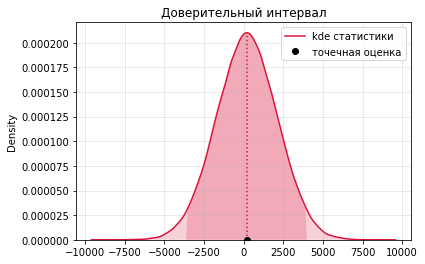

------------------
A/B тест
Значение метрики изменилось на: 201.63043
95.0% доверительный интервал: (-3547.70715, 3932.63723)
Отличия статистически значимые: False
p-value from bootstrap is: 0.91499


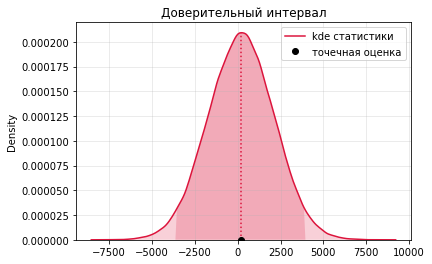

In [203]:
bootstrap(
    values_control_val_cuped,
    values_test_val_cuped,
    np.mean,
    n,
    0,
    verbose=True
)

### MULTITEST CORRECTION

In [ ]:
def multitest_correction(
    *, list_of_pvals: List, alpha: float = 0.05, method: str = 'holm', **kwargs
) -> None:
    """
    Корректировка p-value для множественной проверки гипотез.

    args:
        list_of_pvals - массив рассчитанных p-value значений
        alpha - уровень ошибки первого рода
        method - метод поправки, default: 'holm', подробнее по ссылке
            https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
    """
    decision, adj_pvals, sidak_aplha, bonf_alpha = stats.multitest.multipletests(
        pvals=list_of_pvals, alpha=alpha, method=method)
    return dict(
        decision=list(decision),
        adjusted_pvals=[np.round(i, 10) for i in adj_pvals],
        sidak_aplha=sidak_aplha,
        bonf_alpha=bonf_alpha
    )